# densepose

- https://github.com/facebookresearch/detectron2/blob/main/projects/DensePose/doc/TOOL_APPLY_NET.md
- https://github.com/facebookresearch/detectron2/blob/main/projects/DensePose/doc/DENSEPOSE_IUV.md
    - https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_101_FPN_DL_s1x/165712116/model_final_844d15.pkl

First, lets extract an image from a judo competition photo.

In [1]:
from pathlib import Path
import shutil

path = next(Path('/mnt/c/Users/acmiy/Videos/').glob("*President*.mp4"))
tmp_path = Path("/tmp/video.mp4")
shutil.copy(path, tmp_path)
path, tmp_path

(PosixPath("/mnt/c/Users/acmiy/Videos/vlc-record-2023-11-19-12h42m05s-[Mat 8] 2023 President's Cup-6rZvqhUaxOE.f136.ts-.mp4"),
 PosixPath('/tmp/video.mp4'))

In [3]:
# https://superuser.com/questions/1009969/how-to-extract-a-frame-out-of-a-video-using-ffmpeg
test_frame = "/tmp/test-frame.jpg"
! rm {test_frame}
! ffmpeg -i {tmp_path.as_posix()} -ss 00:00:00.000 -vframes 1 {test_frame}

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

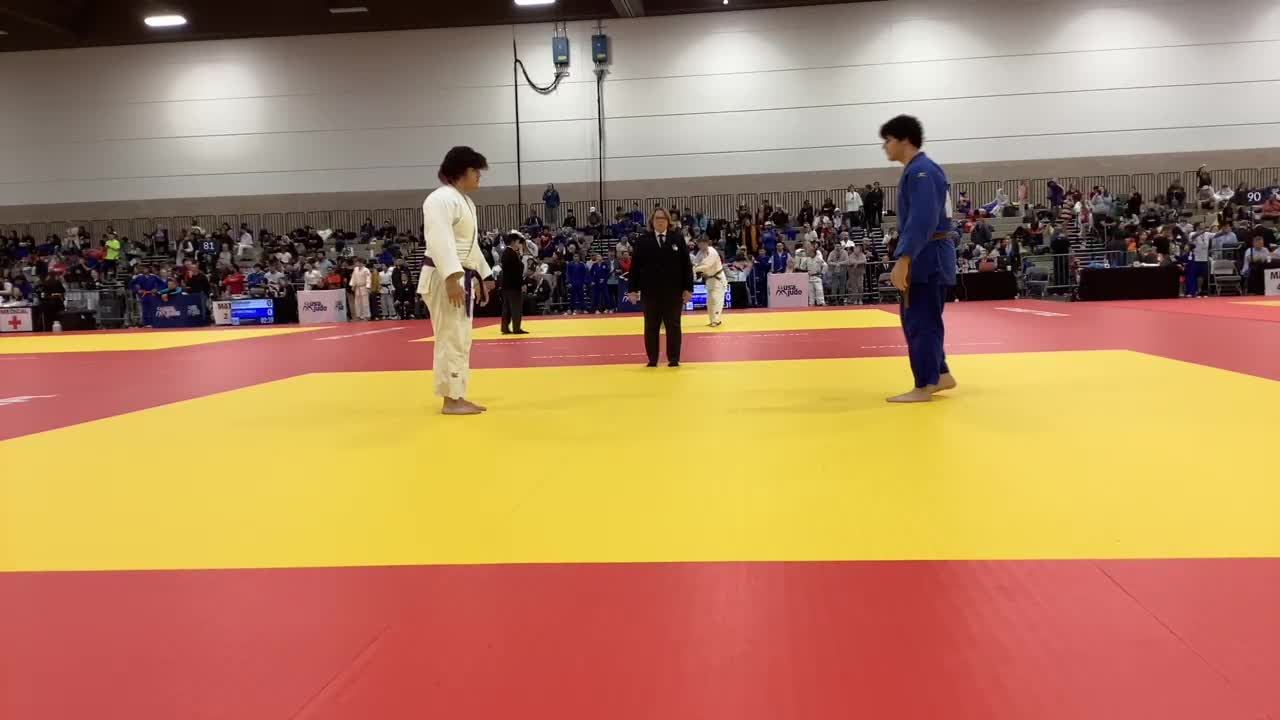

In [ ]:
from IPython.display import display, Image

display(Image(test_frame))

In [4]:
cd ../vendor/detectron2/projects/DensePose

/home/anthony/judo/vendor/detectron2/projects/DensePose


In [ ]:
! ls configs | head

Base-DensePose-RCNN-FPN.yaml
HRNet
cse
densepose_rcnn_R_101_FPN_DL_WC1M_s1x.yaml
densepose_rcnn_R_101_FPN_DL_WC1_s1x.yaml
densepose_rcnn_R_101_FPN_DL_WC2M_s1x.yaml
densepose_rcnn_R_101_FPN_DL_WC2_s1x.yaml
densepose_rcnn_R_101_FPN_DL_s1x.yaml
densepose_rcnn_R_101_FPN_WC1M_s1x.yaml
densepose_rcnn_R_101_FPN_WC1_s1x.yaml


In [39]:
tmp_output = "/tmp/densepose-output.jpg"
! python apply_net.py show configs/densepose_rcnn_R_101_FPN_DL_s1x.yaml  \
    https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_101_FPN_DL_s1x/165712116/model_final_844d15.pkl \
    {test_frame} dp_contour,bbox -v \
    --output {tmp_output}

[11/23 19:46:59 apply_net]: Loading config from configs/densepose_rcnn_R_101_FPN_DL_s1x.yaml
[11/23 19:46:59 apply_net]: Loading model from https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_101_FPN_DL_s1x/165712116/model_final_844d15.pkl
[11/23 19:47:01 apply_net]: Loading data from /tmp/test-frame.jpg
/home/anthony/judo/.venv/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[11/23 19:47:01 apply_net]: Processing /tmp/test-frame.jpg
/home/anthony/judo/vendor/detectron2/projects/DensePose/densepose/vis/densepose_results.py:133: UserWarning: The following kwargs were not used by contour: 'cfg', 'texture_atlas', 'texture_atlases_dict'
  plt.contour(u, self.levels, extent=extent, **self.plot_args)
/home/anthony/judo/vendor/detectron2/

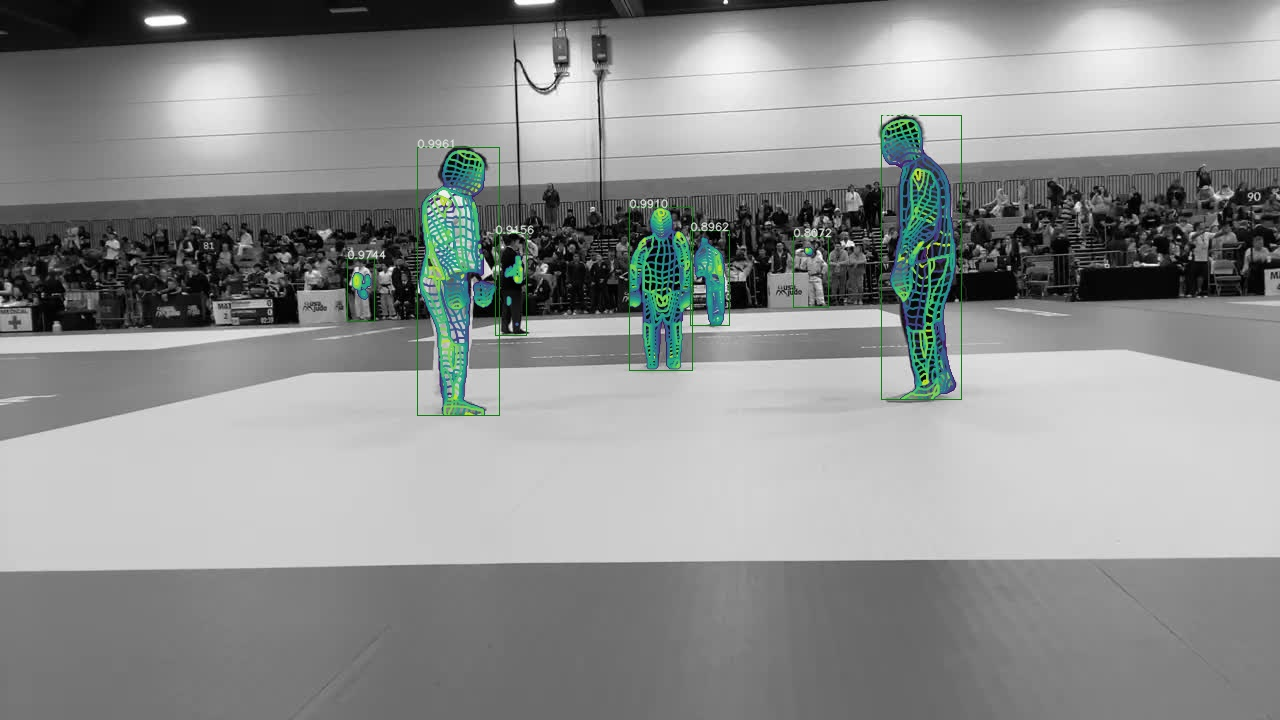

In [41]:
display(Image("/tmp/densepose-output.0001.jpg"))

Let's construct a workflow that will process a video a second at a time, then concatenate the results at the end.
This is going to be much worse than building a workflow that processes the video all at once, but it will be fast enough for a proof of concept.

In [6]:
# extract 10 seconds of frames into a temp directory
! mkdir -p /tmp/judo
! ffmpeg -hide_banner -loglevel error -i {tmp_path.as_posix()} -vf fps=16 /tmp/judo/seq-%04d.jpg

In [32]:
! du -h /tmp/judo

76M	/tmp/judo


In [37]:
# ignore user warnings
tmp_output = Path("/tmp/densepose-output/seq.jpg")
! mkdir -p {tmp_output.parent}
! python apply_net.py show configs/densepose_rcnn_R_101_FPN_DL_s1x.yaml  \
    https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_101_FPN_DL_s1x/165712116/model_final_844d15.pkl \
    /tmp/judo dp_contour,bbox -v \
    --output {tmp_output} \
    >& output.log

^C


In [38]:
! ls /tmp/densepose-output | head

seq.0001.jpg
seq.0002.jpg
seq.0003.jpg
seq.0004.jpg
seq.0005.jpg
seq.0006.jpg
seq.0007.jpg
seq.0008.jpg
seq.0009.jpg
seq.0010.jpg
ls: write error: Broken pipe


In [28]:
tmp_output = Path("/tmp/densepose-output")
# 16 frames per second
! ffmpeg -y -hide_banner -loglevel error \
    -i {tmp_output.as_posix()}/seq.%04d.jpg \
    -c:v libx264 \
    -framerate 16 \
    /tmp/judo-densepose.mp4

In [34]:
tmp_output = Path("/tmp/judo")
# 16 frames per second
! ffmpeg -y -hide_banner -loglevel error \
    -i {tmp_output.as_posix()}/seq-%04d.jpg \
    -c:v libx264 \
    -framerate 16 \
    /tmp/judo-test.mp4

In [35]:
# copy to one drive
! cp /tmp/judo-densepose.mp4 /mnt/c/Users/acmiy/OneDrive/judo/judo-densepose.mp4
! cp /tmp/judo-test.mp4 /mnt/c/Users/acmiy/OneDrive/judo/judo-test.mp4